In [1]:
import os, sys

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii as at
from astropy.table import join,vstack,Table
from scipy import stats

In [2]:
# Read in and merge the outputs from k2spin

base_dir = os.path.expanduser("~/data/tess/ic2391/tables/")
file_list = at.read(os.path.join(base_dir,"IC2391_2021-05-19.lst"))

In [3]:
all_arr = []
for filename in file_list["Filename"]:
    all_arr.append(at.read(os.path.join(base_dir,filename)))

In [4]:
results = vstack(all_arr)

In [5]:
u_tic = np.unique(results["target_name"])

In [6]:
u_tic.dtype

dtype('int64')

In [7]:
N = len(u_tic)
dtype = [('TIC', 'int64'), ('NProt', 'i4'), ('Nclean', 'i4'), ('Prot', 'f8'), ('Prot_avg', 'f8'), ('Prot_std', 'f8')]
summary = Table(data=np.zeros(N, dtype=dtype))

In [8]:
clean_threshold = 0

In [9]:
for i, tic in enumerate(u_tic):
    loc = results["target_name"]==tic
    summary["TIC"][i] = tic
    summary["NProt"][i] = len(np.where(loc)[0])
    clean = np.where(loc & (results["num_sig_peaks"]==clean_threshold) & (results["sig_periods"]>0))[0]
    summary["Nclean"][i] = len(clean)
    if len(clean)>0:
        clean_short = np.where(loc & (results["num_sig_peaks"]==clean_threshold) & (results["sig_periods"]<=12))[0]
        
        if len(clean_short)>0:
            summary["Prot"][i] = results["sig_periods"][clean_short][0]
            summary["Prot_avg"][i] = np.mean(results["sig_periods"][clean_short])
            summary["Prot_std"][i] = np.std(results["sig_periods"][clean_short])
        else:
            summary["Prot"][i] = results["sig_periods"][clean][0]
            summary["Prot_avg"][i] = np.mean(results["sig_periods"][clean])
            summary["Prot_std"][i] = np.std(results["sig_periods"][clean])
            
    else:
        summary["Prot"][i] = -99

# Crossmatch back to Gaia data

In [10]:
gaia = at.read("IC2391_crossmatch_xmatch_TIC.csv")

In [11]:
summary_gaia = join(summary,gaia,keys=["TIC"])

In [12]:
len(summary_gaia)

267

# More filtering

In [13]:
# Read in and merge the outputs from k2spin - all peaks from every periodogram

file_list = at.read(os.path.join(base_dir,"IC2391_2021-05-19_allpeaks.lst"))
all_arr = []
for filename in file_list["Filename"]:
    all_arr.append(at.read(os.path.join(base_dir,filename)))
all_peaks = vstack(all_arr)
all_peaks.rename_column("lc_type","provenance_name")
all_peaks.rename_column("sector","sequence_number")
all_peaks.rename_column("TIC","target_name")

In [30]:
results2 = results.copy()
results2["clean60"] = np.zeros(len(results2),bool)
results2["clean30"] = np.zeros(len(results2),bool)
results2["clean10"] = np.zeros(len(results2),bool)
results2["clean"] = np.zeros(len(results2),bool)
results2["half"] = np.zeros(len(results2),int)
results2["dbl"] = np.zeros(len(results2),int)
# results2["period_long"] = np.ones(len(results2),float)*-99
# results2["power_long"] = np.ones(len(results2),float)*-99
results2["period_short"] = np.ones(len(results2),float)*-99
results2["power_short"] = np.ones(len(results2),float)*-99

In [31]:
for i,row in enumerate(results2):
    
    # Find all the all_peaks locations, by target_name, provenance_name, and sequence_number
    loc = ((all_peaks["target_name"]==row["target_name"]) &
           (all_peaks["provenance_name"]==row["provenance_name"]) &
           (all_peaks["flux_col"]==row["flux_cols"]) &
           (all_peaks["sequence_number"]==row["sequence_number"]))
    loc = np.where(loc)[0]
    
#     print(row["target_name","provenance_name","sequence_number","flux_cols"])
    
    if len(loc)==0:
#         print("no peaks found")
#         print(row["target_name","provenance_name","sequence_number","flux_cols"])
        continue
    elif len(loc)==1:
        results2["clean"][i] = True
        results2["clean10"][i] = True
        results2["clean30"][i] = True
        results2["clean60"][i] = True
        continue
        
    sub_tab = all_peaks[loc]
#     print(sub_tab)

    
    # Are all the other peaks <60% the height of the main peak?
    main = np.argmax(sub_tab["power"])
    max_power = sub_tab["power"][main]
    max_per = sub_tab["period"][main]
    
    contaminants = np.where(sub_tab["power"]>=(0.6*max_power))[0]
    # one match is just going to be the primary peak itself
    ncontam = len(contaminants) -1
    
    if ncontam==0:
        results2["clean60"][i] = True
        print("clean",ncontam,results2["clean"][i])

    else:
        results2["clean60"][i] = False
        print("not clean",ncontam,results2["clean"][i])
    
        # Are there potentially half or double harmonics?
        tolerance = 0.05 
        contam_diff = abs(max_per-sub_tab["period"][contaminants])/max_per
        
        if np.any(abs(contam_diff-0.5)<tolerance):
            results2["half"][i] = 1
#             print("half")
#             print(contam_diff)

        if np.any(abs(contam_diff-2)<tolerance):
            results2["dbl"][i] = 1
#             print("double")
#             print(contam_diff)


    contaminants = np.where(sub_tab["power"]>=(0.3*max_power))[0]
    # one match is just going to be the primary peak itself
    ncontam = len(contaminants) -1
    
    if ncontam==0:
        results2["clean30"][i] = True
        print("clean",ncontam,results2["clean"][i])

    else:
        results2["clean30"][i] = False
        print("not clean",ncontam,results2["clean"][i])
    
    contaminants = np.where(sub_tab["power"]>=(0.1*max_power))[0]
    # one match is just going to be the primary peak itself
    ncontam = len(contaminants) -1
    
    if ncontam==0:
        results2["clean10"][i] = True
        print("clean",ncontam,results2["clean"][i])

    else:
        results2["clean10"][i] = False
        print("not clean",ncontam,results2["clean"][i])
    
    # If the highest peak is >13 days, are there other significant periods?
    if max_per>13:
        short = sub_tab["period"]<=13
        if np.any(short):
#             print("found shorter periods")
            sub_tab2 = sub_tab[short]
            short_max = np.argmax(sub_tab2["power"])
            row["period_short"] = sub_tab2["period"][short_max]
            row["power_short"] = sub_tab2["power"][short_max]
        else:
            continue

clean 0 False
clean 0 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
not clean 3 False
not clean 3 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
clean 0 False
not clean 1 False
not clean 2 False
not clean 2 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 3 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 5 False
clean 0 False
not clean 2 False
not clean 2 False
not clean 1 False
not clean 1 False
not clean 3 False
not clean 1 False
not clean 2 False
not clean 3 False
clean 0 False
clean 0 False


clean 0 False
clean 0 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 3 False
clean 0 False
not clean 2 False
not clean 2 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 1 False
not clean 1 False
not clean 3 False
not clean 4 False
not clean 4 False
not clean 4 False
not clean 1 False
not clean 3 False
not clean 3 False
clean 0 False
not clean 2 False
not clean 4 False
clean 0 False
not clean 3 False
not clean 4 False
clean 0 False
not clean 6 False
not clean 7 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 5 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clea

clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
not clean 2 False
not clean 4 False
clean 0 False
not clean 2 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 3 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 4 False
not clean 5 False
not clean 1 False
not clean 3 False
not clean 6 False
clean 0 False
not clean 2 False
not clean 4 False
clean 0 False
not clean 2 False
not clean 5 False
clean 0 False
not clean 2 False
not clean 4 False
clean 0 False
not clean 2 False
not clean 3 False
clean 0 False
not clean 1 False
not clean 3 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 1 Fa

clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 2 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 2 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not cl

not clean 2 False
not clean 2 False
not clean 4 False
not clean 1 False
not clean 4 False
not clean 5 False
not clean 3 False
not clean 3 False
not clean 3 False
clean 0 False
not clean 1 False
not clean 3 False
not clean 1 False
not clean 2 False
not clean 3 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 1 False
not clean 4 False
not clean 4 False
clean 0 False
not clean 2 False
not clean 5 False
clean 0 False
not clean 2 False
not clean 6 False
clean 0 False
not clean 1 False
not clean 3 False
not clean 1 False
not clean 1 False
not clean 2 False
not clean 1 False
not clean 2 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 3 False
not clean 1 False
not clean 2 False
not clean 3 False


not clean 2 False
not clean 6 False
not clean 6 False
not clean 1 False
not clean 4 False
not clean 4 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 3 False
not clean 3 False
clean 0 False
not clean 1 False
not clean 4 False
clean 0 False
not clean 3 False
not clean 4 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
not clean 2 False
not clean 3 False
clean 0 False
not clean 2 False
not clean 3 False
clean 0 False
not clean 2 False
not clean 3 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 2 False
not clean 1 False
not clean 3 False
not clean 6 False
clean 0 False
not clean 3 Fa

clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 1 False
not clean 4 False
not clean 5 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 2 False
not clean 2 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 1 False
not clean 2 False
not clean 2 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 5 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 1 False
not clean 1 False
not clean 4 False
not clean 6 False
not cl

clean 0 False
not clean 1 False
not clean 2 False
not clean 1 False
not clean 4 False
not clean 7 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
not clean 2 False
not clean 4 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 3 False
not clean 6 False
clean 0 False
not clean 1 False
not clean 2 False
not clean 1 False
not clean 7 False
not clean 13 False
not clean 4 False
not clean 8 False
not clean 10 False
not clean 1 False
not clean 1 False
not clean 8 False
not clean 1 False
not clean 4 False
not clean 10 False
not clean 4 False
not clean 8 False
not clean 10 False
not clean 1 False
not clean 1 False
not clean 8 False
clean 0 False
not clean 2 False
not clean 7 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 

clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 2 False
not clean 1 False
not clean 2 False
not clean 2 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 3 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 2 False
not clean 5 False
clean 0 False
clean 0 False
not clean 1 Fals

clean 0 False
not clean 2 False
not clean 3 False
not clean 1 False
not clean 3 False
not clean 4 False
not clean 1 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 1 False
not clean 3 False
not clean 7 False
clean 0 False
not clean 1 False
not clean 4 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 2 False
not clean 3 False
not clean 6 False
clean 0 False
no

clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
not clean 2 False
not clean 4 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 1 False
not clean 2 False
not clean 2 False
not clean 1 False
not clean 2 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 5 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 2 False
not clean 1 False
not clean 2 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 2 False
not clean 1 False
not clean 4 False
not clean 4 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 1 False
not clean 1 False
not clean 1 Fa

clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 3 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 5 False
not clean 1 False
not clean 2 False
not clean 6 False
clean 0 False
not clean 3 False
not clean 4 False
not clean 3 False
not clean 3 False
not clean 3 False
clean 0 False
not clean 2 False
not clean 2 False
not clean 1 False
not clean 1 False
not clean 4 False
not clean 3 False
not clean 4 False
not clean 6 False
clean 0 False
not clean 3 False
not clean 5 False
clean 0 False
not clean 2 False
not clean 4 False
clean 0 False
not clean 2 False
not clean 3 False
clean 0 False
not clean 2 False
not clean 3 False
not clean 1 False
not clean 2 False
not clean 3 False
not clean 1 False
not clean 1 Fals

clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 1 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 4 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 3 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 1 False
not clean 3 False
not clean 3 False
clean 0 False
not clean 1 

clean 0 False
not clean 2 False
not clean 5 False
not clean 4 False
not clean 6 False
not clean 6 False
not clean 1 False
not clean 3 False
not clean 4 False
not clean 1 False
not clean 2 False
not clean 2 False
not clean 1 False
not clean 2 False
not clean 2 False
not clean 2 False
not clean 3 False
not clean 3 False
not clean 3 False
not clean 6 False
not clean 6 False
not clean 3 False
not clean 4 False
not clean 4 False
not clean 2 False
not clean 3 False
not clean 9 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
not clean 2 False
not clean 2 False
clean 0 False
clean 0 False
not clean 4 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
clean 0 False
not clean 4 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 2 False
not clean 1 False
not clean 1 False
not clean 2 False
clean 0 False
clean 0 False
clean 

clean 0 False
not clean 1 False
not clean 5 False
not clean 2 False
not clean 4 False
not clean 4 False
clean 0 False
not clean 2 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 2 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
clean 0 False
clean 0 False
clean 0 False
not clean 1 False
not clean 2 False
not clean 1 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 3 False
clean 0 False
clean 0 False
not clean 1 False
clean 0 False
clean 0 False
not clean 3 False
clean 0 False
clean 0 False
not clean 2 False
clean 0 False
not clean 2 False
not clean 3 False
clean 0 False
clean 0 False
not clean 3 False
not clean 2 False
not clean 4 False
not clean 4 False
not clean 1 False
not clean 3 False
not clean 3 False
clean 0 False
not clean 1 False
not clean 4 False
clean 0 False
not clean 1 False
not clean 2 False
clean 0 False
not clean 1 False
not clean 2 False
not clean 2 Fals

In [32]:
results2["target_name","provenance_name","sequence_number","flux_cols","sig_periods","clean","clean60","clean30","half","dbl"].show_in_notebook()

idx,target_name,provenance_name,sequence_number,flux_cols,sig_periods,clean,clean60,clean30,half,dbl
0,44999952,CDIPS,8,TFA1,0.3078,False,True,True,0,0
1,44999952,CDIPS,9,TFA1,0.3079,False,True,False,0,0
2,44999952,CDIPS,10,TFA1,0.3075,False,True,True,0,0
3,45049176,PATHOS,8,psf_flux_cor,32.6843,False,True,True,0,0
4,45049176,PATHOS,9,psf_flux_cor,3.309,False,True,False,0,0
5,45050711,CDIPS,8,TFA1,0.7763,False,True,False,0,0
6,45050711,CDIPS,9,TFA1,0.7747,True,True,True,0,0
7,45050711,CDIPS,10,TFA1,0.7755,False,True,True,0,0
8,45050711,PATHOS,8,psf_flux_cor,19.9067,False,False,False,1,0
9,45050711,PATHOS,9,psf_flux_cor,25.4777,False,True,False,0,0


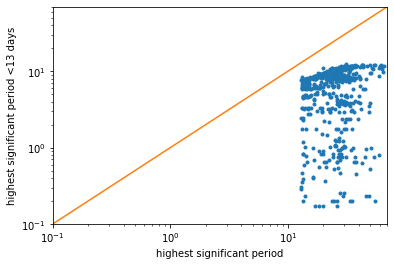

In [51]:
plt.plot(results2["sig_periods"],results2["period_short"],'.')
plt.xlim(0.1,70)
plt.ylim(0.1,70)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("highest significant period")
plt.ylabel("highest significant period <13 days")
x = np.linspace(0.1,70,20)
plt.plot(x,x)
# So just cutting off at 12 days is not actually a useful filter here

In [55]:
N = len(u_tic)
dtype = [('TIC', 'int64'), ('NProt', 'i4'), ('Nclean', 'i4'), ('Prot', 'f8'), ('Prot_avg', 'f8'), ('Prot_std', 'f8'),
         ('provenance_name','a6'),('sequence_number','i4'),('flux_cols','a12')]
summary2 = Table(data=np.zeros(N, dtype=dtype))

In [62]:
for i, tic in enumerate(u_tic):
    loc = results2["target_name"]==tic
    summary2["TIC"][i] = tic
    summary2["NProt"][i] = len(np.where(loc)[0])
    clean = np.where(loc & (results2["clean10"]==True) & (results2["sig_periods"]>0))[0]
    summary2["Nclean"][i] = len(clean)
    
    if len(clean)>0:
        clean_short = np.where(loc & (results2["clean10"]==True) & 
                               (results2["sig_periods"]>0) & (results2["sig_periods"]<=13))[0]
        
        if len(clean_short)==1:
            summary2["Prot"][i] = results2["sig_periods"][clean_short][0]
            summary2["Prot_avg"][i] = np.mean(results2["sig_periods"][clean_short])
            summary2["Prot_std"][i] = np.std(results2["sig_periods"][clean_short])
            summary2["provenance_name"][i] = results2["provenance_name"][clean_short][0]
            summary2["sequence_number"][i] = results2["sequence_number"][clean_short][0]
            summary2["flux_cols"][i] = results2["flux_cols"][clean_short][0]
        elif len(clean_short)>1:
            sub_tab = results2[clean_short]
            best = np.argmax(sub_tab["sig_powers"])
            summary2["Prot"][i] = sub_tab["sig_periods"][best]
            summary2["Prot_avg"][i] = np.mean(sub_tab["sig_periods"])
            summary2["Prot_std"][i] = np.std(sub_tab["sig_periods"])            
        else:
            summary2["Prot"][i] = results2["sig_periods"][clean][0]
            summary2["Prot_avg"][i] = np.mean(results2["sig_periods"][clean])
            summary2["Prot_std"][i] = np.std(results2["sig_periods"][clean])
            
    else:
        summary2["Prot"][i] = -99
        

In [63]:
summary2.show_in_notebook()

idx,TIC,NProt,Nclean,Prot,Prot_avg,Prot_std,provenance_name,sequence_number,flux_cols
0,44999952,18,2,0.3075,0.30765,0.00015000000000001124,,0,
1,45049176,8,1,37.592,37.592,0.0,,0,
2,45050711,30,4,0.7747,0.77415,0.0007664854858378188,,0,
3,45184491,18,8,0.6919,0.6923874999999999,0.0005904182839309539,,0,
4,45402598,30,9,0.6543,0.65432,0.0001326649916142014,,0,
5,45402925,20,0,-99.0,2.87624,0.005674363400417759,,0,
6,45404408,30,9,0.757,2.025211111111111,3.5856992547384814,,0,
7,45407296,18,0,-99.0,0.0,0.0,,0,
8,45781130,20,2,2.085,2.0857,0.0006999999999999229,,0,
9,45786218,20,6,1.0977,1.0959,0.0017088007490634782,,0,


In [64]:
summary2_gaia = join(summary2,gaia,keys=["TIC"])

In [65]:
# OH DUH. The summary table is already cleaned. 
# This is just telling me the number of clean periods included in the average
std_avg = summary_gaia["Prot_std"]/summary_gaia["Prot_avg"]
std_avg2 = summary2_gaia["Prot_std"]/summary2_gaia["Prot_avg"]
clean = (summary_gaia["Nclean"]>0) & (std_avg<=0.1)
clean2 = (summary2_gaia["Nclean"]>0) & (std_avg2<=0.1)

/Users/stephanie/anaconda3/envs/lightkurve/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/stephanie/anaconda3/envs/lightkurve/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [66]:
bp_rp = summary_gaia["GAIAEDR3_BP"] - summary_gaia["GAIAEDR3_RP"]
bp_rp2 = summary2_gaia["GAIAEDR3_BP"] - summary2_gaia["GAIAEDR3_RP"]

130


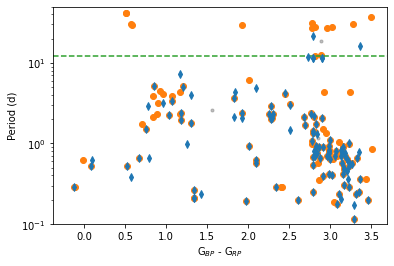

In [67]:
plt.plot(bp_rp,summary_gaia["Prot"],'.',color="grey",alpha=0.5)
plt.plot(bp_rp[clean],summary_gaia["Prot"][clean],'d',ms=5,zorder=5)
plt.plot(bp_rp2[clean2],summary2_gaia["Prot"][clean2],'o')
# plt.plot(bp_rp2[clean2],summary2_gaia["Prot_avg"][clean2],'s',zorder=-2)
print(len(np.where(clean2)[0]))

plt.ylim(0.1,50)
plt.yscale("log")

plt.xlabel(r"G$_{BP}$ - G$_{RP}$")
plt.ylabel("Period (d)")

ax = plt.gca()
ax.axhline(12,linestyle="--",color="C2")

In [69]:
long_m = clean2 & (bp_rp2>2.5) & (summary2_gaia["Prot"]>10)
print(summary2_gaia["TIC"][long_m])

   TIC   
---------
 45049176
 90455790
 92583309
 92740254
 92744248
 93273595
 93549955
 94104642
145446486
